Please upload your wiki article files. You can upload:
1. Individual .txt files
2. A ZIP file containing .txt files
3. Multiple files at once


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saving wiki_article.txt to wiki_article.txt
Saving wiki_article_0.txt to wiki_article_0.txt
Saving wiki_article_1.txt to wiki_article_1.txt
Saving wiki_article_2.txt to wiki_article_2.txt
Saving wiki_article_3.txt to wiki_article_3.txt
Saving wiki_article_4.txt to wiki_article_4.txt
Saving wiki_article_5.txt to wiki_article_5.txt
Saving wiki_article_6.txt to wiki_article_6.txt
Saving wiki_article_7.txt to wiki_article_7.txt
Saving wiki_article_8.txt to wiki_article_8.txt
Saving wiki_article_9.txt to wiki_article_9.txt
Processing wiki_article.txt...
Loaded: wiki_article.txt
Processing wiki_article_0.txt...
Loaded: wiki_article_0.txt
Processing wiki_article_1.txt...
Loaded: wiki_article_1.txt
Processing wiki_article_2.txt...
Loaded: wiki_article_2.txt
Processing wiki_article_3.txt...
Loaded: wiki_article_3.txt
Processing wiki_article_4.txt...
Loaded: wiki_article_4.txt
Processing wiki_article_5.txt...
Loaded: wiki_article_5.txt
Processing wiki_article_6.txt...
Loaded: wiki_article_6.txt


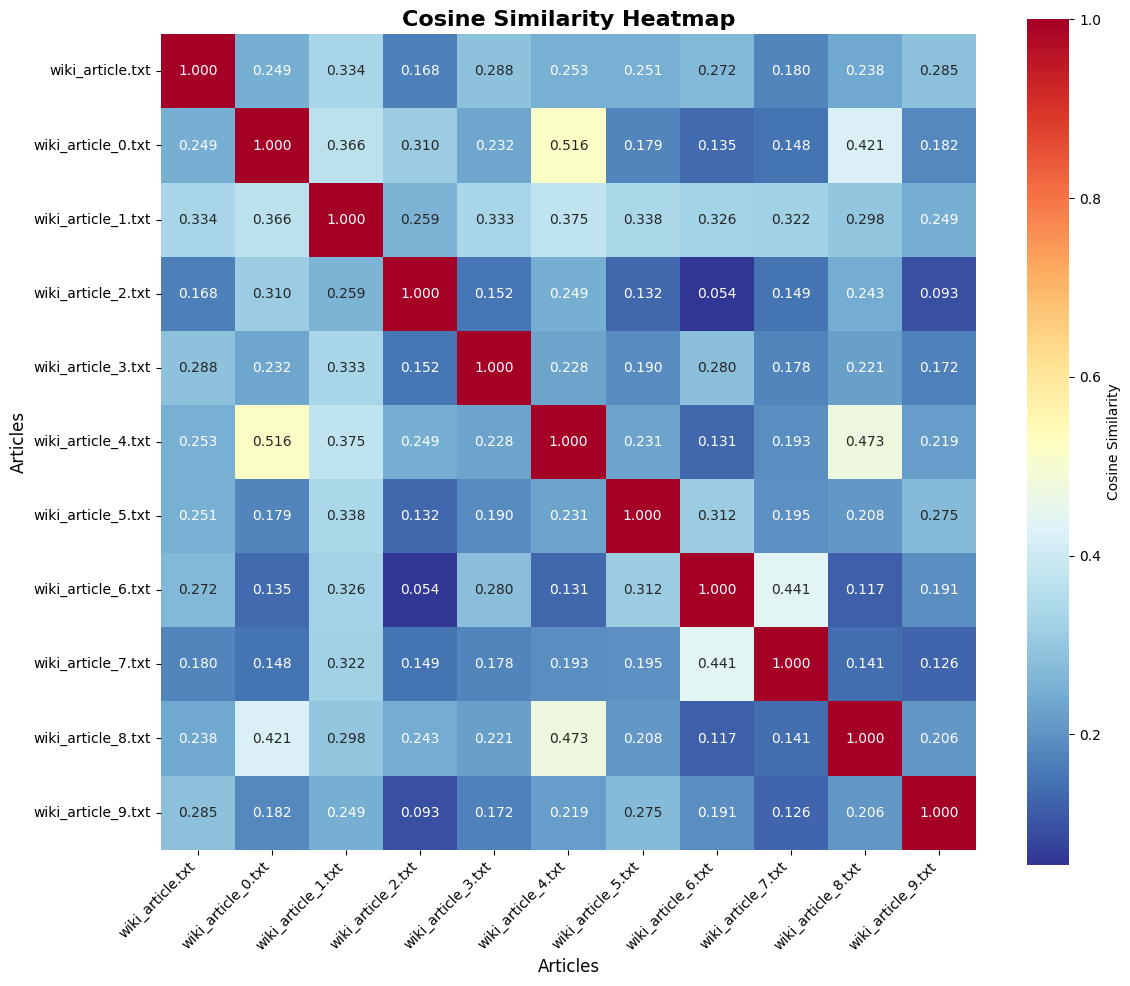

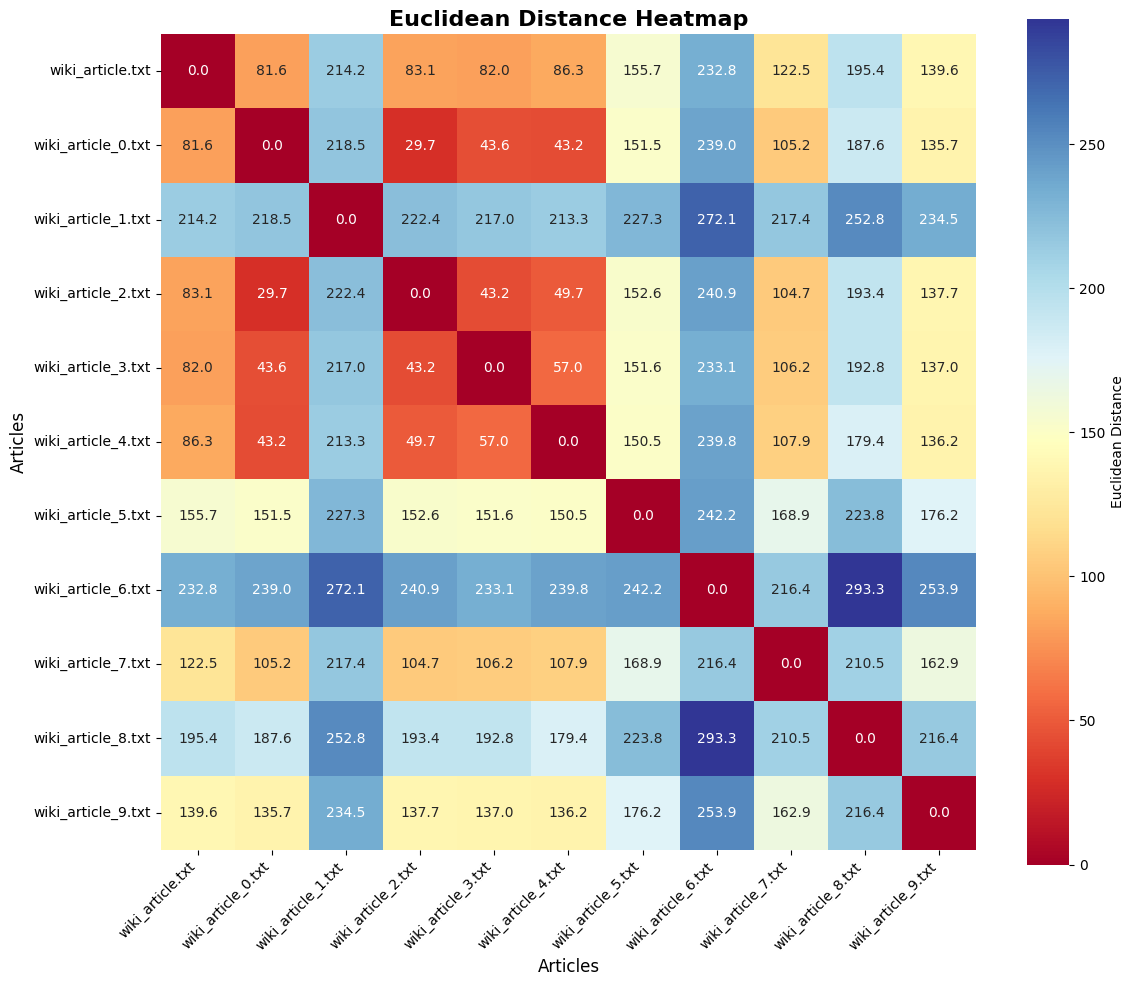

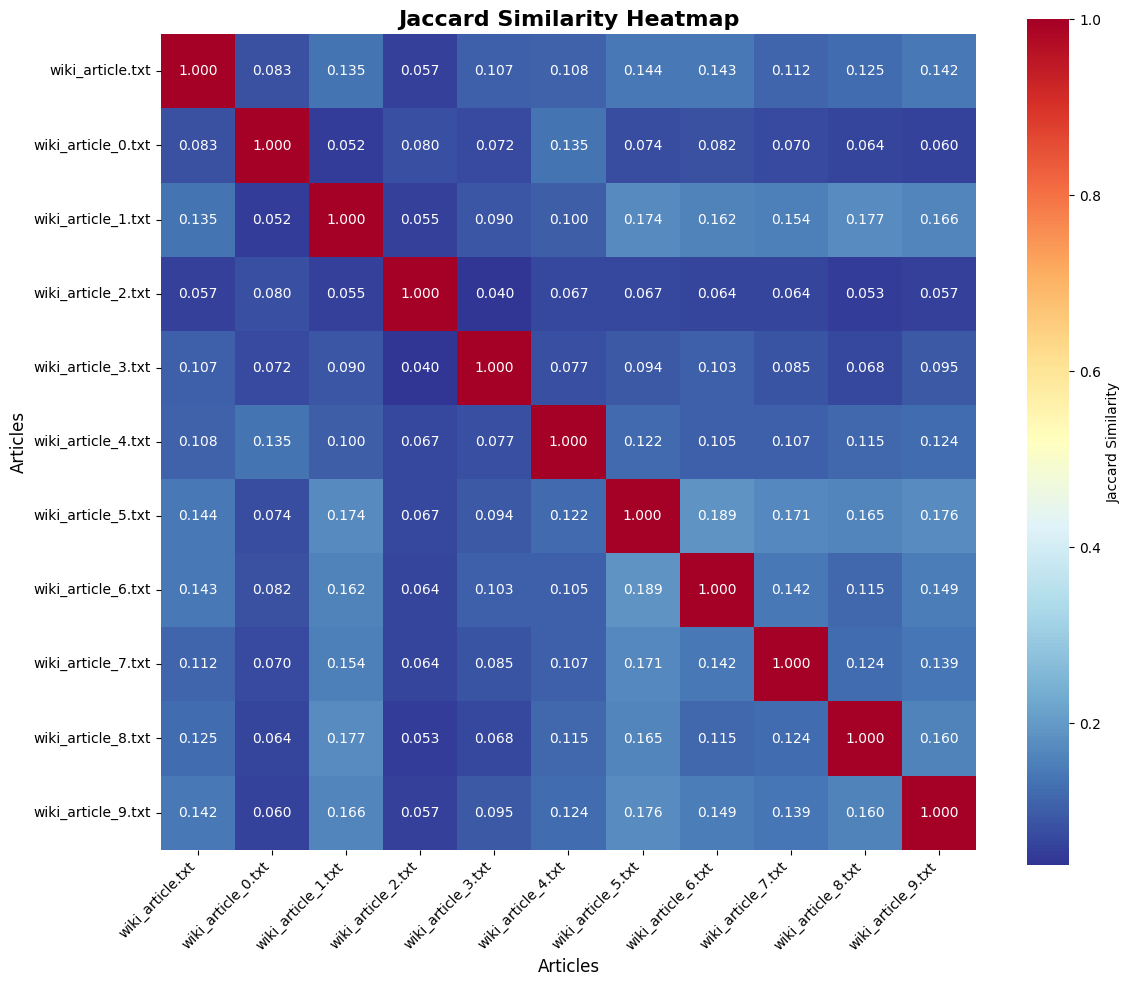

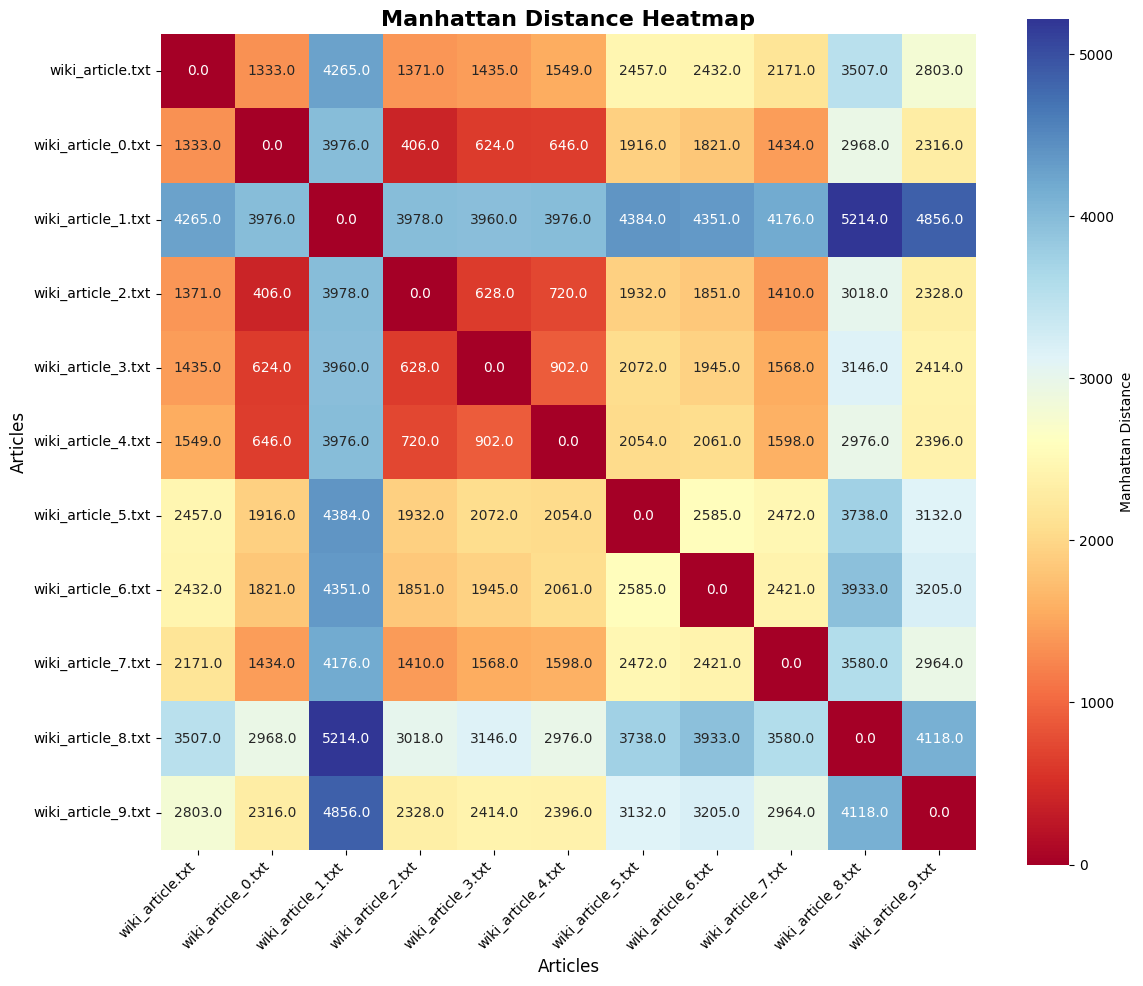


SUMMARY STATISTICS
Number of articles: 11
Number of article pairs: 55

Metrics Summary:
       cosine_similarity  euclidean_distance  manhattan_distance  \
count            55.0000             55.0000             55.0000   
mean              0.2420            166.9518           2572.5818   
std               0.0953             67.9630           1192.6342   
min               0.0544             29.6985            406.0000   
25%               0.1783            115.2175           1709.5000   
50%               0.2322            176.2328           2421.0000   
75%               0.2929            220.4114           3543.5000   
max               0.5155            293.3002           5214.0000   

       jaccard_similarity  
count             55.0000  
mean               0.1084  
std                0.0406  
min                0.0396  
25%                0.0707  
50%                0.1066  
75%                0.1420  
max                0.1893  

------------------------------
MOST SIMILAR P

In [ ]:
# Install required packages
!pip install pandas scikit-learn numpy nltk matplotlib seaborn scipy

import nltk
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import euclidean, cityblock, cosine
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from google.colab import files

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("Please upload your wiki article files. You can upload:")
print("1. Individual .txt files")
print("2. A ZIP file containing .txt files")
print("3. Multiple files at once")

# Upload files
uploaded = files.upload()

# Process uploaded files
wiki_articles = []
filenames = []

for filename, content in uploaded.items():
    print(f"Processing {filename}...")

    if filename.endswith('.zip'):
        # Handle ZIP files
        with open(filename, 'wb') as f:
            f.write(content)

        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('extracted_files')

        # Load extracted files
        for extracted_file in os.listdir('extracted_files'):
            if extracted_file.endswith('.txt'):
                filepath = os.path.join('extracted_files', extracted_file)
                with open(filepath, 'r', encoding='utf-8') as f:
                    article_content = f.read()
                    if article_content.strip():  # Only add non-empty files
                        wiki_articles.append(article_content)
                        filenames.append(extracted_file)
                        print(f"Loaded: {extracted_file}")

    elif filename.endswith('.txt'):
        # Handle individual text files
        try:
            article_content = content.decode('utf-8')
            if article_content.strip():  # Only add non-empty files
                wiki_articles.append(article_content)
                filenames.append(filename)
                print(f"Loaded: {filename}")
        except UnicodeDecodeError:
            print(f"Warning: Could not decode {filename} as UTF-8")

# Check if any articles were loaded
if not wiki_articles:
    raise ValueError("No valid text files found. Please upload .txt files or a ZIP containing .txt files.")

# Create a DataFrame from the articles
wiki_df = pd.DataFrame({
    'article': wiki_articles,
    'filename': filenames
})
print(f"\nSuccessfully loaded {len(wiki_df)} articles.")
print("Article filenames:", filenames)

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text: str) -> list:
    """Preprocess text by tokenizing, removing stop words, and lemmatizing."""
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    alpha_tokens = [token for token in tokens if token.isalpha()]  # Keep only alphabetic tokens
    no_stop_tokens = [token for token in alpha_tokens if token not in stop_words]  # Remove stop words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in no_stop_tokens]  # Lemmatize tokens
    return lemmatized_tokens

def bow_to_vector(bow: list, vocab: list) -> np.ndarray:
    """Convert bag of words to vector representation."""
    return np.array([bow.count(word) for word in vocab])

def compute_metrics(article1: str, article2: str) -> dict:
    """Compute similarity and distance metrics between two articles."""
    # Preprocess articles
    tokens1 = preprocess_text(article1)
    tokens2 = preprocess_text(article2)

    # Handle edge case where one or both articles have no valid tokens
    if not tokens1 and not tokens2:
        return {
            'cosine_similarity': 1.0,  # Both empty, completely similar
            'euclidean_distance': 0.0,
            'manhattan_distance': 0.0,
            'jaccard_similarity': 1.0
        }
    elif not tokens1 or not tokens2:
        return {
            'cosine_similarity': 0.0,  # One empty, completely dissimilar
            'euclidean_distance': float('inf'),
            'manhattan_distance': float('inf'),
            'jaccard_similarity': 0.0
        }

    # Create a deterministic ordered vocabulary (sorted for reproducibility)
    vocab = sorted(set(tokens1).union(set(tokens2)))

    # Convert to Bag of Words vectors
    vector1 = bow_to_vector(tokens1, vocab)
    vector2 = bow_to_vector(tokens2, vocab)

    # Manual Jaccard similarity on token sets
    set1, set2 = set(tokens1), set(tokens2)
    union = set1 | set2
    intersection = set1 & set2
    jaccard_similarity = (len(intersection) / len(union)) if union else 0.0

    # Compute metrics
    try:
        cosine_sim = 1 - cosine(vector1, vector2)
        # Handle NaN case (when vectors are zero)
        if np.isnan(cosine_sim):
            cosine_sim = 0.0
    except:
        cosine_sim = 0.0

    metrics = {
        'cosine_similarity': cosine_sim,
        'euclidean_distance': euclidean(vector1, vector2),
        'manhattan_distance': cityblock(vector1, vector2),
        'jaccard_similarity': jaccard_similarity
    }
    return metrics

def compute_all_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Compute metrics for all pairs of articles."""
    metrics_list = []
    total_pairs = len(df) * (len(df) - 1) // 2
    print(f"Computing metrics for {total_pairs} article pairs...")

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            article1 = df.iloc[i]['article']
            article2 = df.iloc[j]['article']
            metrics = compute_metrics(article1, article2)
            metrics['article1'] = df.iloc[i]['filename']
            metrics['article2'] = df.iloc[j]['filename']
            metrics_list.append(metrics)

    return pd.DataFrame(metrics_list)

# Process all articles and compute metrics
if len(wiki_df) < 2:
    print("Warning: Need at least 2 articles to compute similarity metrics.")
else:
    metrics_df = compute_all_metrics(wiki_df)
    print(f"\nComputed metrics for {len(metrics_df)} pairs of articles.")

    # Display the metrics DataFrame
    print("\nSimilarity Metrics:")
    print(metrics_df.round(4))

    # Create visualization matrices
    articles = sorted(set(metrics_df['article1']).union(metrics_df['article2']))
    n_articles = len(articles)

    # Initialize matrices
    cosine_mat = pd.DataFrame(1.0, index=articles, columns=articles)  # Diagonal = 1 for similarity
    euclidean_mat = pd.DataFrame(0.0, index=articles, columns=articles)  # Diagonal = 0 for distance
    jaccard_mat = pd.DataFrame(1.0, index=articles, columns=articles)  # Diagonal = 1 for similarity
    manhattan_mat = pd.DataFrame(0.0, index=articles, columns=articles)  # Diagonal = 0 for distance

    # Fill matrices with computed values
    for _, row in metrics_df.iterrows():
        a1, a2 = row['article1'], row['article2']
        cosine_mat.at[a1, a2] = row['cosine_similarity']
        cosine_mat.at[a2, a1] = row['cosine_similarity']
        euclidean_mat.at[a1, a2] = row['euclidean_distance']
        euclidean_mat.at[a2, a1] = row['euclidean_distance']
        jaccard_mat.at[a1, a2] = row['jaccard_similarity']
        jaccard_mat.at[a2, a1] = row['jaccard_similarity']
        manhattan_mat.at[a1, a2] = row['manhattan_distance']
        manhattan_mat.at[a2, a1] = row['manhattan_distance']

    # Create visualizations
    plt.style.use('default')  # Ensure consistent plotting style

    # Cosine Similarity Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cosine_mat, annot=True, fmt=".3f", cmap='RdYlBu_r',
                square=True, cbar_kws={'label': 'Cosine Similarity'})
    plt.title('Cosine Similarity Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Articles', fontsize=12)
    plt.ylabel('Articles', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Euclidean Distance Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(euclidean_mat, annot=True, fmt=".1f", cmap='RdYlBu',
                square=True, cbar_kws={'label': 'Euclidean Distance'})
    plt.title('Euclidean Distance Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Articles', fontsize=12)
    plt.ylabel('Articles', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Jaccard Similarity Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(jaccard_mat, annot=True, fmt=".3f", cmap='RdYlBu_r',
                square=True, cbar_kws={'label': 'Jaccard Similarity'})
    plt.title('Jaccard Similarity Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Articles', fontsize=12)
    plt.ylabel('Articles', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Manhattan Distance Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(manhattan_mat, annot=True, fmt=".1f", cmap='RdYlBu',
                square=True, cbar_kws={'label': 'Manhattan Distance'})
    plt.title('Manhattan Distance Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Articles', fontsize=12)
    plt.ylabel('Articles', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Number of articles: {len(articles)}")
    print(f"Number of article pairs: {len(metrics_df)}")
    print("\nMetrics Summary:")
    print(metrics_df[['cosine_similarity', 'euclidean_distance',
                     'manhattan_distance', 'jaccard_similarity']].describe().round(4))

    # Find most and least similar pairs
    print("\n" + "-"*30)
    print("MOST SIMILAR PAIRS (Cosine)")
    print("-"*30)
    top_similar = metrics_df.nlargest(3, 'cosine_similarity')
    for _, row in top_similar.iterrows():
        print(f"{row['article1']} ↔ {row['article2']}: {row['cosine_similarity']:.4f}")

    print("\n" + "-"*30)
    print("LEAST SIMILAR PAIRS (Cosine)")
    print("-"*30)
    least_similar = metrics_df.nsmallest(3, 'cosine_similarity')
    for _, row in least_similar.iterrows():
        print(f"{row['article1']} ↔ {row['article2']}: {row['cosine_similarity']:.4f}")

print("\nAnalysis complete! Upload your wiki article files to get started.")